Paramteric approach for image classificaiton, with f(x,W) = W x on the CIFAR10 dataset,
where W is found by brute force

In [ ]:
import pandas as pd
import cupy as cp
from matplotlib import pyplot  as plt
from keras.datasets import cifar10

In [ ]:
# define functions for easier computations

def softmax(g):
    y = cp.exp(g)
    return y / cp.sum(y)

def loss(decision_label, true_label):
    return -cp.dot(true_label, cp.log(decision_label))

def label_vec_func(labels):
    labels_matrix = cp.zeros([len(labels), 10])
    labels_matrix[cp.arange(len(labels)), labels] = 1
    return labels_matrix

def funk(x, W):
    x = cp.reshape(x, (1024, 50000))
    f = cp.matmul(W, x)
    f /= cp.max(f, axis=0)
    return f

In [ ]:
# load the data from keras dataset
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

# specify the labels for human understanding
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# remove some training samples because of the computer power
X_train = cp.array(X_train)
y_train = label_vec_func(cp.array(y_train.reshape(-1)))
X_test = cp.array(X_test)
y_test = label_vec_func(cp.array(y_test.reshape(-1)))

# checking the size of the training and testing data
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000, 10)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000, 10)


This is cat


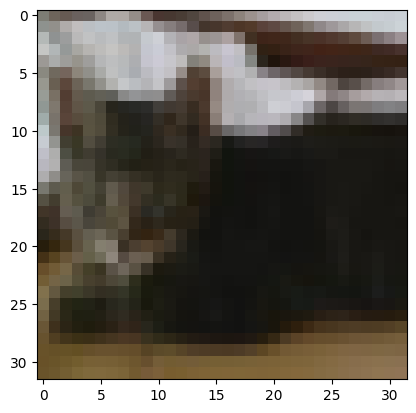

In [ ]:
# show one of the images
img = X_train[9, :]
plt.imshow(img.get())
print("This is", labels[int(cp.argmax(y_train[9]))])

In [ ]:
# turn the training and the test sets into the grayscale
X_train_gray = cp.array([cp.average(image, axis=2).reshape(-1) for image in X_train])
X_test_gray = cp.array([cp.average(image, axis=2).reshape(-1) for image in X_test])

In [ ]:
print(X_train_gray.shape)

(50000, 1024)


This is cat


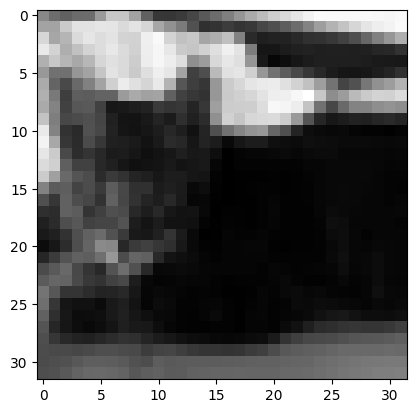

In [ ]:
# show one of the grayscale images
img = X_train_gray[9, :].reshape(32, 32)
plt.imshow(img.get(), cmap='gray')
print("This is", labels[int(cp.argmax(y_train[9]))])

In [ ]:
n = 500
min_L = 10**10
good_W = None

# try to get W n times
for i in range(n):
    W = cp.random.randn(10, 1024)
    l = cp.zeros((X_train_gray.shape[0], 10000))

    # compute the output
    g = funk(X_train_gray, W)
    y = softmax(g)

    # compute the loss for batches of size 10000 in order not to go out of memory
    for batch in range(X_train_gray.shape[0] // 10000):
        start = batch * 10000
        end = min((batch + 1) * 10000, X_train_gray.shape[0])

        l[start:end] = loss(y[:, start:end], y_train[start:end])

    L = cp.mean(l)

    # remember the best W according to loss
    if min_L > L:
        print(L)
        good_W = W
        min_L = L

13.34865750228947
13.336521757038172
13.280201966585857
13.256504903652688
13.227328948416975
13.208057704004567
13.202729960602186
13.192403909241639


In [ ]:
decision_label = cp.zeros(10000)
true_label = cp.zeros(10000)

# compute the result for the test images using the best set of parameters
y = cp.matmul(good_W, X_test_gray.T)
decision_label = cp.argmax(y, axis=0)
true_label = cp.argmax(y_test.T, axis=0)

# compute accuracy
accuracy = cp.sum(decision_label == true_label)/len(decision_label)

In [ ]:
print(accuracy)

0.1149
